# Calibrating tied meta parameters

## About this document

This document was generated from a jupyter notebook. It illustrates how to set up a calibration where a global parameterization is set at the catchment level, with scaled values for each subareas. This method helps to keep the degrees of freedom of an optimisation to a minimum.

## Imports

In [1]:
from swift2.vis import OptimisationPlots, plot_two_series
import xarray as xr
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
import swift2

In [3]:
# Only temporary, under construction...
import swift2.wrap.swift_wrap_generated as swg
import swift2.wrap.swift_wrap_custom as swc

In [4]:
from swift2.system import *
from swift2.simulation import *
from swift2.play_record import *
from swift2.utils import *
from swift2.parameteriser import *
from swift2.statistics import *
from swift2.doc_helper import *
# from swift2.prototypes import extractOptimizationLog

from uchronia.time_series import get_item



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from cinterop.timeseries import TIME_DIMNAME, slice_xr_time_series, pd_series_to_xr_series, slice_xr_time_series, pd_series_to_xr_series

In [7]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
import datetime as dt

In [8]:
%matplotlib inline

In [9]:
# flowDs = loadTxtDataSet(file.path(dataDir, 'ovens_flow_hydstra+aifs_utc_2000_LBfilled.txt'))
# dataNodeIds = clrCall(flowDs, "getNodeIds")
# abbeyardDataIndex = which(dataNodeIds=='36')
# abbeyardSiteName = clrCall(flowDs, "getSiteIds")[abbeyardDataIndex]
# abbeyardFlowTs = getHourlyTs(flowDs, abbeyardDataIndex)
# abbeyardFlowTs[which(abbeyardFlowTs < -1)] = NA

We need to adjust the observed flow, as the SWIFTv1 legacy missing value code is not consistent with default handling in SAK. Note that I *think* the flow included in the sample data is the Ovens catchment outlet, but I am not sure!

In [10]:
flow = sample_series('Abbeyard', 'flow')

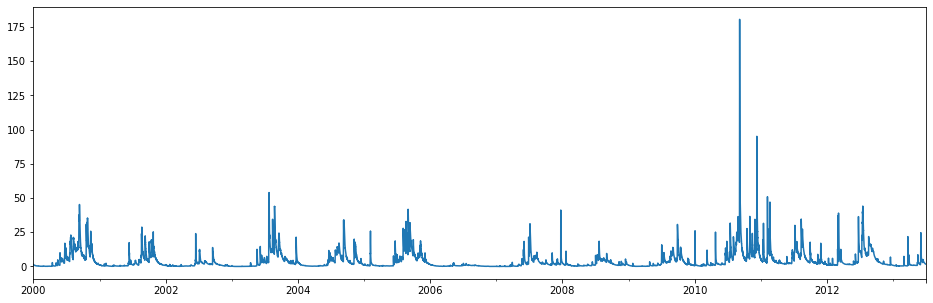

In [11]:
flow.plot(figsize=(16,5));

## Creating a realistic (?) model

We create a system with areas similar to the real use case, but do note that test catchment structure is just an arbitrary default one, suitable for this example, but probably not a valid model.

In [12]:
areasKm2 = [91.2627, 95.8716, 6.5610, 128.4822, 93.0042]
mss = create_test_catchment_structure(areas_km2 = areasKm2)

In [13]:
ms = mss[1]
ms = swap_model(ms, 'Muskingum', 'channel_routing')

We will run over a few years and calibrate with a warmup of two years.

In [14]:
flow.index[0]

Timestamp('2000-01-01 00:00:00')

In [15]:
e = xr_ts_end(flow) - dt.timedelta(days=2)

In [16]:
w = e - pd.DateOffset(years=10)
s = w - pd.DateOffset(years=2)

In [17]:
ms = configure_test_simulation(ms, data_id = "Ovens", simul_start = s, 
    simul_end = e, tstep = "hourly", 
    varname_rain = "P", varname_pet = "E",
    varname_data_rain = 'rain', varname_data_pet = 'evap') 

The package includes a function that flags possible inconsistencies prior to running a model (inconsistent time steps, etc.)

In [18]:
check_simulation(ms)

{'errors': []}

We need to adjust a couple of parameters for proper operation on hourly data for the GR4 model structure.

In [19]:
pGr4jHourly = create_gr4jh_parameters()
pGr4jHourly.as_dataframe()
pGr4jHourly.apply_sys_config(ms)

We now define a meta parameter set with area scaling applied to x4 and time scaling applied to x2 and x3.

In [20]:
refArea = 250
timeSpan = int(dt.timedelta(hours=1).seconds)
p = gr4j_scaled_parameteriser(refArea, timeSpan)

In [21]:
print(p.as_dataframe())

  Name  Value  Min     Max
0   x2   30.0  1.0   400.0
1   x3   10.0  0.0  1000.0
2   x4   14.0  1.0   240.0
3   x1   44.6  1.0  1000.0


In [22]:
pspec_gr4j = pd.DataFrame(dict(Name=['x1','x2','x3','x4'], 
    Min = [1.0E+00, -2.70E+01, 1.0E+00, 1.0E+00],
    Max = [5.0E+03,  2.70E+01, 6.6E+02, 2.4E+02],
    Value = [6.5E+02,  -0.28, 7.9, 18.9]) )

In [23]:
p.set_hypercube(pspec_gr4j)
p.as_dataframe()

,Name,Value,Min,Max
0,x2,-0.28,-27.0,27.0
1,x3,7.90,1.0,660.0
2,x4,18.90,1.0,240.0
3,x1,650.00,1.0,5000.0


In [24]:
p = p.wrap_transform()
p.add_transform('log_x4', 'x4', 'log10')

We can inspect the values of one of the subareas to check that the parameter values applied are indeed scaled. For instance x4 is scaled based on the area

In [25]:
p.as_dataframe()

,Name,Value,Min,Max
0,log_x4,1.276462,0.0,2.380211
1,x2,-0.280000,-27.0,27.000000
2,x3,7.900000,1.0,660.000000
3,x1,650.000000,1.0,5000.000000


In [26]:
subareaIds = paste('subarea', get_subarea_ids(ms), sep='.')
areas = get_state_value(ms, paste(subareaIds, 'areaKm2', sep='.') )
x4ParamIds = paste(subareaIds, 'x4', sep='.')
get_state_value(ms, x4ParamIds)
p.apply_sys_config(ms)
get_state_value(ms, x4ParamIds)

{'subarea.lnk1.x4': 11.4192730183668,
 'subarea.lnk2.x4': 11.704066684020558,
 'subarea.lnk3.x4': 3.0618,
 'subarea.lnk4.x4': 13.549188412890272,
 'subarea.lnk5.x4': 11.52771100990999}

Build the definition of the optimisation task. TODO: improve ways to search for element keys by element names.

In [27]:
outflowVarname = "Catchment.StreamflowRate"
record_state(ms, outflowVarname)

In [28]:
ms.exec_simulation()
calc = ms.get_recorded(outflowVarname)



In [29]:
flow = as_xarray_series(flow)

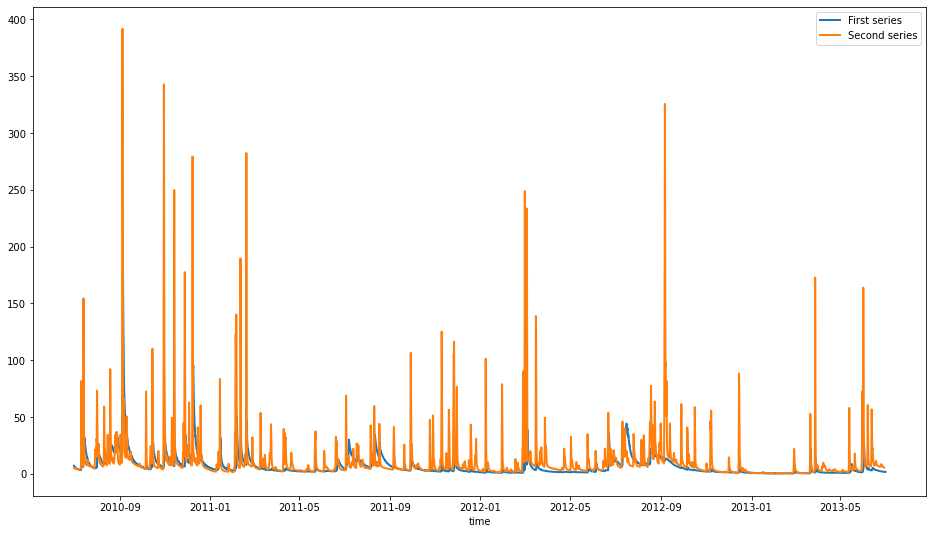

In [30]:
vis_e = as_timestamp(xr_ts_end(flow))
vis_s = vis_e-pd.DateOffset(years=3)

plot_two_series(flow, calc, start_time=vis_s , end_time=vis_e)

In [31]:
objective = ms.create_objective(outflowVarname, flow, 'NSE', w, e)
score = objective.get_score(p)
print(score)

{'scores': {'NSE': -3.544615571758257}, 'sysconfig':      Name       Value   Min          Max
0  log_x4    1.276462   0.0     2.380211
1      x2   -0.280000 -27.0    27.000000
2      x3    7.900000   1.0   660.000000
3      x1  650.000000   1.0  5000.000000}


We have our objectives defined, and the parameter space 'p' in which to search. Let's create an optimiser and we are ready to go. While the optimiser can be created in one line, we show how to choose one custom termination criterion and how to configure the optimiser to capture a detailed log of the process.

In [32]:
if 'SWIFT_FULL' in os.environ.keys():
    max_hours = 0.2 
else:
    max_hours = 0.02

# term = getMarginalTermination(tolerance = 1e-05, cutoff_no_improvement = 30, max_hours = max_hours) 
term = get_max_runtime_termination(max_hours = max_hours) 
sce_params = get_default_sce_parameters()
urs = create_parameter_sampler(0, p, 'urs')
optimiser = create_sce_optim_swift(objective, term, sce_params, urs)
calib_logger = set_calibration_logger(optimiser, '')

At this point you may want to specify the maximum number of cores that can be used by the optimiser, for instance if you wish to keep one core free to work in parallel on something else.

In [33]:
sce_params

{'P': 6,
 'Pmin': 6,
 'M': 9,
 'Q': 7,
 'Alpha': 1,
 'Beta': 9,
 'NumShuffle': 40,
 'TrapezoidalDensityParameter': 1.0,
 'ReflectionRatio': -1.0,
 'ContractionRatio': 0.5}

The number of complexes is 6; by default the optimiser will try to use 6 CPU cores in parallel, or n-1 where N is your number of cores and less than 6. It is possible to limit the level of parallelism if needed. 

In [34]:
# TODO add an API entry point for SetMaxDegreeOfParallelismHardwareMinus

In [35]:
%%time
calib_results = optimiser.execute_optimisation()

CPU times: user 6min 28s, sys: 1.16 s, total: 6min 29s
Wall time: 1min 13s


Processing the calibration log:

In [36]:
opt_log = extract_optimisation_log(optimiser, fitness_name = "NSE")
geom_ops = opt_log["geom_ops"] 

We can then visualize how the calibration evolved. There are several types of visualisations included in the **mhplot** package, and numerous customizations possible, but starting with the overall population evolution:

In [37]:
geom_ops._data['NSE'].describe()

count      521.000000
mean      -304.046052
std       4412.095029
min     -84821.560145
25%          0.319724
50%          0.521361
75%          0.595546
max          0.621601
Name: NSE, dtype: float64

In [38]:
p_var_ids = p.as_dataframe().Name.values
p_var_ids

array(['log_x4', 'x2', 'x3', 'x1'], dtype=object)

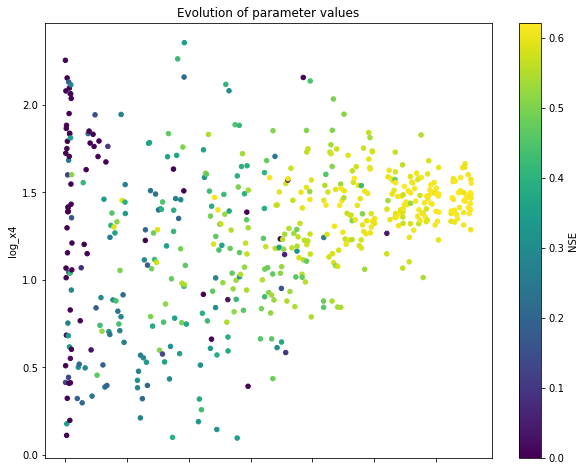

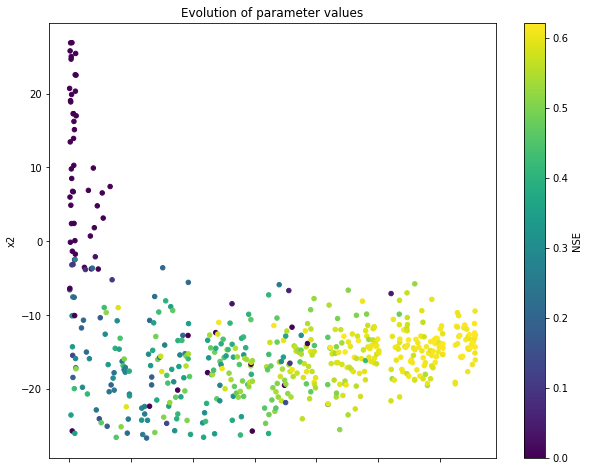

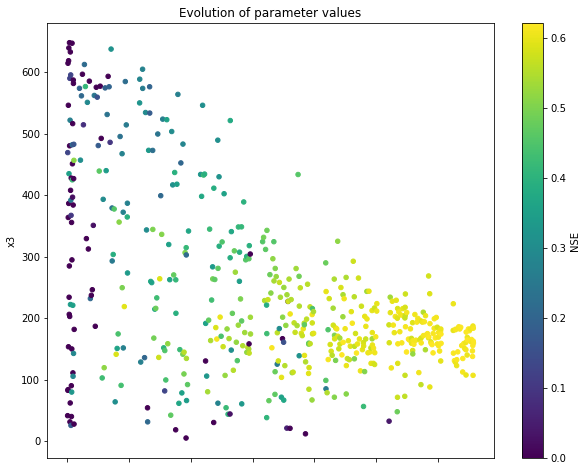

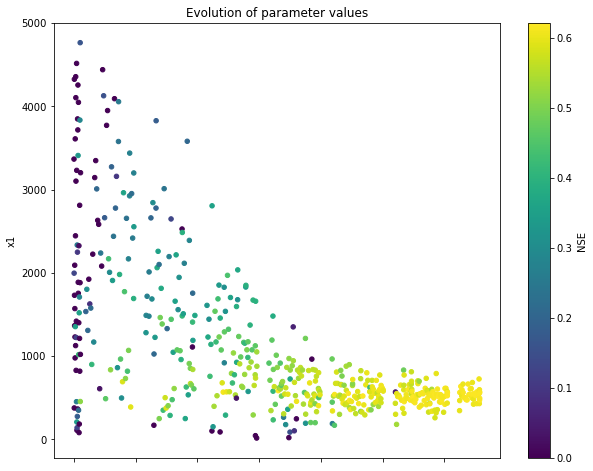

In [39]:
v = OptimisationPlots(geom_ops)
for pVarId in p_var_ids:
    v.parameter_evolution(pVarId, obj_lims=[0,1])
    plt.gcf().set_size_inches(10,8)

In [40]:
# sortedResults = sortByScore(calib_results, 'NSE')
# best_pset = getScoreAtIndex(sortedResults, 1)
# best_pset = GetSystemConfigurationWila_R(best_pset)

In [41]:
best_pset = calib_results.get_best_score('NSE').parameteriser

*swift* can back-transform a parameters to obtain the untransformed parameter set(s):

In [42]:
best_pset

     Name       Value   Min          Max
0  log_x4    1.498092   0.0     2.380211
1      x2  -12.389076 -27.0    27.000000
2      x3  137.645347   1.0   660.000000
3      x1  548.276874   1.0  5000.000000

In [43]:
untfPset = backtransform(best_pset)
score = objective.get_score(best_pset)
score

{'scores': {'NSE': 0.6216012843957801},
 'sysconfig':      Name       Value   Min          Max
 0  log_x4    1.498092   0.0     2.380211
 1      x2  -12.389076 -27.0    27.000000
 2      x3  137.645347   1.0   660.000000
 3      x1  548.276874   1.0  5000.000000}

In [44]:
score = objective.get_score(untfPset)
score

{'scores': {'NSE': 0.6216012843957801},
 'sysconfig':   Name       Value   Min     Max
 0   x2  -12.389076 -27.0    27.0
 1   x3  137.645347   1.0   660.0
 2   x4   31.484145   1.0   240.0
 3   x1  548.276874   1.0  5000.0}

Finally, let's have a visual of the fitted streamflow data at Abbeyard:

In [45]:
best_pset.apply_sys_config(ms)
ms.exec_simulation()
mod_runoff = ms.get_recorded(outflowVarname)

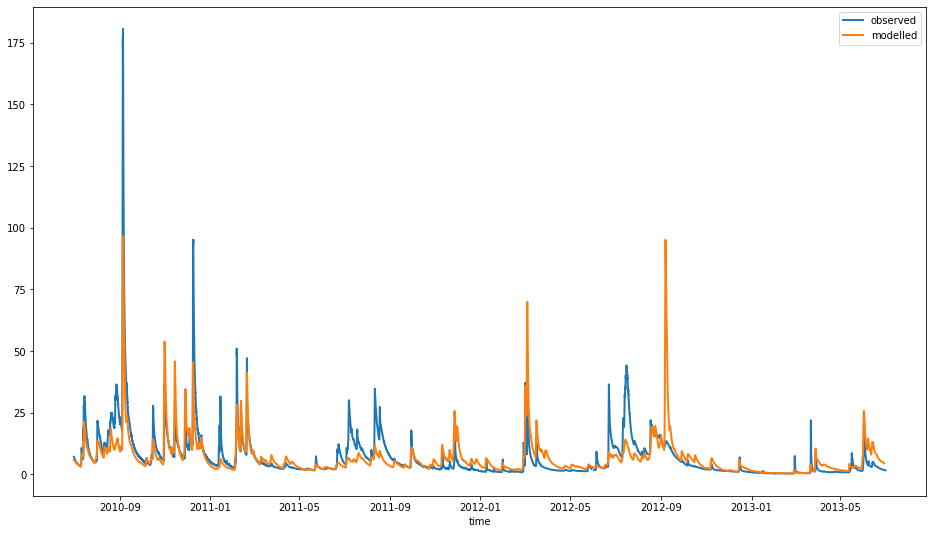

In [46]:
plot_two_series(flow, mod_runoff, start_time=vis_s , end_time=vis_e, names=['observed','modelled'])